In [64]:
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import math

In [65]:
# config
# image_folder = r'D:\Dataset\kittimot\testing\image_02'
# calib_folder = r'D:\Dataset\kittimot\testing\calib'
data_path = r'G:\내 드라이브\Dataset\kittimot\testing'
image_folder = r'G:\내 드라이브\data\kittimot\testing\image_02'
calib_folder = r'G:\내 드라이브\data\kittimot\testing\calib'
oxts_folder = r'G:\내 드라이브\data\kittimot\testing\oxts'

calib_list = sorted(glob.glob(os.path.join(calib_folder, '*.txt')))

SEQ = 0# training: 0~20, testing: 0~28
FRAME = 402
image_list = sorted(glob.glob(os.path.join(image_folder, f'{SEQ:04d}', '*.png')))

yolo_result_folder = './results/yolov5_test'
yolo_label_list = sorted(glob.glob(os.path.join(yolo_result_folder, '*.txt')))
rrcCar_result_folder = './results/rrc_car_test'
rrcCar_result_list = sorted(glob.glob(os.path.join(rrcCar_result_folder, '*.txt')))
pointrcnn_result_folder_df = './results/pointrcnn_test/deepfusionmot/'
pointrcnn_result_list_df = sorted(glob.glob(os.path.join(pointrcnn_result_folder_df, '*.txt')))
pointrcnn_result_folder_pius = './results/pointrcnn_test/pius/'
pointrcnn_result_list_pius = sorted(glob.glob(os.path.join(pointrcnn_result_folder_pius, '*.txt')))

In [66]:
def load_label(label_list, seq):
    with open(label_list[seq], 'r') as f:
        label = f.read().splitlines()
    label = np.array([x.split(',') for x in label])
    return label

# visualize 2D

In [67]:
def make_rect(label, frame, sequence, dim = '2d'):
    r'''
    args:
        label: 2d [frame, left, top, right, bottom, score], 3d [frame, id, left, top, right, bottom, score, h, w, l, x, y, z, r_y, alpha]
        frame: frame number
        sequence: sequence number
        dim: '2d' or '3d'
    '''
    if not dim.lower() in ['2d', '3d']:
        raise ValueError('dim should be 2d or 3d')
    
    if dim.lower() == '2d':
        rect = np.array([x[1:5] for x in label if x[0] == f'{frame}'], dtype=np.float32)
    elif dim.lower() == '3d':
        rect = np.array([x[2:6] for x in label if x[0] == f'{frame}'], dtype=np.float32)
    
    return rect

In [68]:
def draw_projected_box3d(image, qs, color=(255,255,255), thickness=2):
    ''' Draw 3d bounding box in image
        qs: (8,2) array of vertices for the 3d box in following order:
            1 -------- 0
           /|         /|
          2 -------- 3 .
          | |        | |
          . 5 -------- 4
          |/         |/
          6 -------- 7
    '''
    if qs is not None:
        qs = qs.astype(np.int32)
        for k in range(0,4):
           i,j=k,(k+1)%4
           image = cv2.line(image, (qs[i,0],qs[i,1]), (qs[j,0],qs[j,1]), color, thickness) # use LINE_AA for opencv3

           i,j=k+4,(k+1)%4 + 4
           image = cv2.line(image, (qs[i,0],qs[i,1]), (qs[j,0],qs[j,1]), color, thickness)

           i,j=k,k+4
           image = cv2.line(image, (qs[i,0],qs[i,1]), (qs[j,0],qs[j,1]), color, thickness)
    return image

# cv2 image plt show method
def imshow(title = "Image", image = None, size = 20, rect = None, corners_2d = None):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # draw 2d bbox
    for r in rect if rect is not None else []:
        img = cv2.rectangle(img, (int(r[0]), int(r[1])), (int(r[2]), int(r[3])), (0, 255, 0), 2)
    
    # draw 3d bbox
    for corners in corners_2d if corners_2d is not None else []:
        img = draw_projected_box3d(img, corners, color = (255, 0, 0), thickness = 1)
    
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(img)
    plt.axis( "off" )
    plt.title(title)
    plt.show()
    
def readLabel(label_path):
    with open(label_path,  "r" ) as f:
        label = f.read().splitlines()
    return label

def showkitti(idx: int, datasets, rect, split: str = "test", seq: int = None, frame: int = None):
    r'''
    args:
        - idx(int): index of the image
        - datasets(str): "kitti" or "kittimot"
        - split(str): test
        - seq(int): sequence number train: 0 ~ 20, test: 0 ~ 28
        - frame(int): frame number
    '''
    
    SPLIT = {"train": "training", "test": "testing"}
    
    if datasets == "kitti":
        kitti_path = f"/data/hwang/datasetss/{datasets}" # your kitti path
        image_list = glob(os.path.join(kitti_path, SPLIT[split], "image_2", "*.png"))
        image_list.sort()
        label_list = glob(os.path.join(kitti_path, SPLIT[split], "label_2", "*.txt"))
        label_list.sort()

        label = np.array([x.split(' ') for x in readLabel(label_list[idx]) if not x[:4] == 'Dont']).reshape(-1, 15)
        rect = np.array([x[4:8].astype(np.float32) for x in label])

        imshow("Image", cv2.imread(image_list[idx]), size = 30, rect=rect)
        print(label)
        
    elif datasets == "kittimot":
        kitti_path = f"/data/hwang/datasetss/{datasets}" # your kittimot path
        
        image_list = glob(os.path.join(kitti_path, SPLIT[split], "image_02",f'{seq:04d}', "*.png"))
        label_list = glob(os.path.join(kitti_path, SPLIT[split], "label_02", "*.txt"))
        image_list.sort()
        label_list.sort()
        
        try:
            label = np.array([x.split(' ') for x in readLabel(label_list[seq])]).reshape(-1, 17)
        except:
            print("not enough arguments")
        
        rect = np.array([x[6:10].astype(np.float32) for x in label if x[0] == f'{frame}' and x[2] != 'DontCare'])
        imshow("Image", cv2.imread(image_list[frame]), size = 30, rect=rect)
        for l in label:
            if l[0] == str(frame) and l[2] != "DontCare":
                print(l)

In [69]:
# pointrcnn label
yolo_label = load_label(yolo_label_list, SEQ)
pointrcnn_label = load_label(pointrcnn_result_list_df, SEQ)
pointrcnn_label_pius = load_label(pointrcnn_result_list_pius, SEQ)

In [70]:
image = cv2.imread(image_list[FRAME])
rect_2d = make_rect(yolo_label, FRAME, SEQ, dim='2d')
rect_3d_df = make_rect(pointrcnn_label, FRAME, SEQ, dim='3d')
rect_3d_pius = make_rect(pointrcnn_label_pius, FRAME, SEQ, dim='3d')

In [71]:
#imshow("Image", image, size = 40, rect=rect_3d_df)
#imshow("Image", image, size = 40, rect=rect_3d_pius)

# Calculate rotation y

In [72]:
from collections import namedtuple
from pykitti import utils

oxts_files = sorted(glob.glob(oxts_folder + '/*.txt'))

def _poses_from_oxts(oxts_packets):
    """Helper method to compute SE(3) pose matrices from OXTS packets.
        args:
            - oxts_packets: list of OXTS packets
        returns:
            - poses: list of SE(3) pose matrices(4x4)
    """
    er = 6378137.  # earth radius (approx.) in meters

    # compute scale from first lat value
    scale = np.cos(oxts_packets[0].lat * np.pi / 180.)

    t_0 = []    # initial position
    poses = []  # list of poses computed from oxts
    for packet in oxts_packets:
        # Use a Mercator projection to get the translation vector
        tx = scale * packet.lon * np.pi * er / 180.
        ty = scale * er * \
            np.log(np.tan((90. + packet.lat) * np.pi / 360.))
        tz = packet.alt
        t = np.array([tx, ty, tz])

        # We want the initial position to be the origin, but keep the ENU
        # coordinate system
        if len(t_0) == 0:
            t_0 = t

        # Use the Euler angles to get the rotation matrix
        Rx = utils.rotx(packet.roll)
        Ry = utils.roty(packet.pitch)
        Rz = utils.rotz(packet.yaw)
        R = Rz.dot(Ry.dot(Rx)) # R = Rz * Ry * Rx

        # Combine the translation and rotation into a homogeneous transform
        poses.append(utils.transform_from_rot_trans(R, t - t_0))

    return poses, Rx, Ry, Rz


OxtsPacket = namedtuple('OxtsPacket',
                                'lat, lon, alt, ' +
                                'roll, pitch, yaw, ' +
                                'vn, ve, vf, vl, vu, ' +
                                'ax, ay, az, af, al, au, ' +
                                'wx, wy, wz, wf, wl, wu, ' +
                                'pos_accuracy, vel_accuracy, ' +
                                'navstat, numsats, ' +
                                'posmode, velmode, orimode')
print("seq: ", SEQ)
oxts_packets = []
filename = oxts_files[SEQ]
with open(filename, 'r') as f:
    for line in f.readlines():
        line = line.split()
        # Last five entries are flags and counts
        line[:-5] = [float(x) for x in line[:-5]]
        line[-5:] = [int(float(x)) for x in line[-5:]]

        data = OxtsPacket(*line)
        oxts_packets.append(data)

# Precompute the IMU poses in the world frame
T_w_imu = _poses_from_oxts(oxts_packets)[0]

# Bundle into an easy-to-access structure
OxtsData = namedtuple('OxtsData', 'packet, T_w_imu')


seq:  0


# visualize 3D boxes on 2D image

In [73]:
import cv2, random
from PIL import Image
from datasets.coordinate_transformation import *

MAX_COLOR = 30
SCORE_THRESHOLD = -10000
WIDTH = 1242
HEIGHT = 374

In [74]:
oxts = OxtsData(oxts_packets[FRAME], T_w_imu[FRAME])
print(oxts)

OxtsData(packet=OxtsPacket(lat=49.009822510688, lon=8.4306836926444, alt=114.67571258545, roll=-0.003468, pitch=0.011189, yaw=-0.084128673205103, vn=-0.70001391675166, ve=8.600332153166, vf=8.6286966775861, vl=-0.038332603730281, vu=-0.11527368584225, ax=-0.28284168676836, ay=0.28686796168359, az=9.7714637067011, af=-0.17161884200966, al=0.33044035343917, au=9.7728597013782, wx=0.016232413712196, wy=-0.0036495903410566, wz=0.029263742974114, wf=0.016564349628687, wl=-0.0035203565213941, wu=0.029085575476889, pos_accuracy=0.6667953209194, vel_accuracy=0.040311288741493, navstat=4, numsats=6, posmode=5, velmode=5, orimode=0), T_w_imu=array([[  0.9964009 ,   0.0839903 ,   0.01144054, 215.02059665],
       [ -0.08402421,   0.99646054,   0.00251555,  78.79377982],
       [ -0.01118877,  -0.00346778,   0.99993139,  -1.90731812],
       [  0.        ,   0.        ,   0.        ,   1.        ]]))


In [75]:
def getyaw(angle):
    return angle * math.atan2(oxts.packet.ve, oxts.packet.vn)

In [76]:
pointrcnn_bbox3d = np.array([x[7:].astype(np.float32) for x in pointrcnn_label if x[0] == f'{FRAME}']) # [h, w, l, x, y, z, ry] [z, -x, -y, l, w, h, -pitch]
#pointrcnn_bbox3d[0][5] += 3
calib_file = calib_list[SEQ]
corners_3d = []
for bbox3d in pointrcnn_bbox3d:
    corners_3d.append(compute_box_3dto2d(bbox3d, calib_file))
corners_3d = np.array(corners_3d)

In [77]:
import math
pointrcnn_bbox3d_pius = np.array([x[7:].astype(np.float32) for x in pointrcnn_label_pius if x[0] == f'{FRAME}'])
# change x -> -y,  y -> -x
#pointrcnn_bbox3d_pius = [[x[0], x[1], x[2], -x[4], -x[3]+1.1, x[5], x[6]+np.pi/2] for x in pointrcnn_bbox3d_pius]
corners_3d_pius = []
for idx, bbox3d in enumerate(pointrcnn_bbox3d_pius):
    corners_3d_pius.append(compute_box_3dto2d(bbox3d, calib_file))
corners_3d_pius = np.array(corners_3d_pius)

C:\Users\bk221\AppData\Local\Temp\ipykernel_12232\2793819907.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  corners_3d_pius = np.array(corners_3d_pius)


In [78]:
pointrcnn_bbox3d_pius.shape

(10, 8)

In [79]:

def roty(angle):
    c = np.cos(angle)
    s = np.sin(angle)
    return np.array([[c, 0, s],
                     [0, 1, 0],
                     [-s, 0, c]])

def rotz(angle):
    c = np.cos(angle)
    s = np.sin(angle)
    return np.array([[c, -s, 0],
                     [s, c, 0],
                     [0, 0, 1]])

def rotx(angle):
    c = np.cos(angle)
    s = np.sin(angle)
    return np.array([[1, 0, 0],
                     [0, c, -s],
                     [0, s, c]])



In [80]:
for idx, bbox3d in enumerate(pointrcnn_bbox3d):
    print(f'{idx+1}: ', [str(x) for x in bbox3d], end='\n')

1:  ['1.4678', '1.5771', '3.8853', '-4.7418', '1.6649', '14.2399', '-0.6363', '-0.3149']
2:  ['1.9754', '1.7993', '4.57', '2.8206', '1.675', '21.9623', '-1.5921', '-1.7198']
3:  ['1.5622', '1.6621', '4.2111', '-5.1824', '1.7057', '19.9535', '2.6815', '2.9356']
4:  ['1.4464', '1.5846', '3.9773', '-5.4666', '1.6883', '5.6946', '2.5987', '3.3636']
5:  ['1.486', '1.6082', '3.7634', '1.8701', '1.7802', '43.6744', '-1.6727', '-1.7155']
6:  ['1.4362', '1.592', '4.0226', '2.818', '1.7435', '14.5093', '-1.5378', '-1.7297']
7:  ['1.478', '1.5676', '3.7745', '3.0606', '1.7614', '33.8642', '-1.6539', '-1.744']
8:  ['1.5164', '1.5898', '3.9993', '-5.115', '1.643', '16.6097', '-0.6941', '-0.3953']
9:  ['1.5399', '1.5703', '3.4747', '1.2592', '1.705', '48.5656', '-1.6053', '-1.6313']
10:  ['1.4769', '1.6134', '4.0783', '-1.4441', '0.0118', '71.6536', '1.5508', '1.5709']
11:  ['1.5604', '1.5972', '4.0277', '-5.2552', '1.7926', '25.7697', '2.71', '2.9112']
12:  ['1.5367', '1.6063', '4.0704', '-5.43', '

In [81]:
# print not exponential number
np.set_printoptions(suppress=True)
#print(pointrcnn_bbox3d_pius)
for idx, bbox3d in enumerate(pointrcnn_bbox3d_pius):
    print(f'{idx+1}: ', [str(x) for x in bbox3d], end='\n')

1:  ['1.4326', '1.5806', '3.8306', '-4.7419', '1.8862', '14.6006', '-0.66229635', '-0.908536']
2:  ['1.4987', '1.6114', '3.9142', '-5.5599', '1.955', '3.0409', '-0.5577963', '-1.012959']
3:  ['1.4077', '1.64', '4.4606', '-5.5215', '1.9904', '5.9267', '-0.5408037', '2.111572']
4:  ['1.4947', '1.6051', '3.8342', '1.8209', '1.6454', '43.8763', '-1.702789', '-3.00956']
5:  ['1.6425', '1.6956', '4.2403', '-4.9961', '1.8476', '20.2386', '-0.52310365', '2.093879']
6:  ['2.0041', '1.8385', '4.8779', '2.8183', '1.6371', '22.3488', '-1.6002964', '0.029489']
7:  ['1.66', '1.7287', '4.3898', '-5.3506', '1.9141', '0.4236', '-0.6292963', '-0.941468']
8:  ['1.6172', '1.7502', '4.7069', '-5.1185', '1.8351', '16.9333', '-0.6861963', '-0.884627']
9:  ['1.5753', '1.6275', '3.9167', '1.0398', '1.6583', '48.9058', '-1.7202964', '0.14951']
10:  ['1.3913', '1.5606', '3.6224', '2.8078', '1.8295', '-0.4299', '-1.6728964', '0.102137']


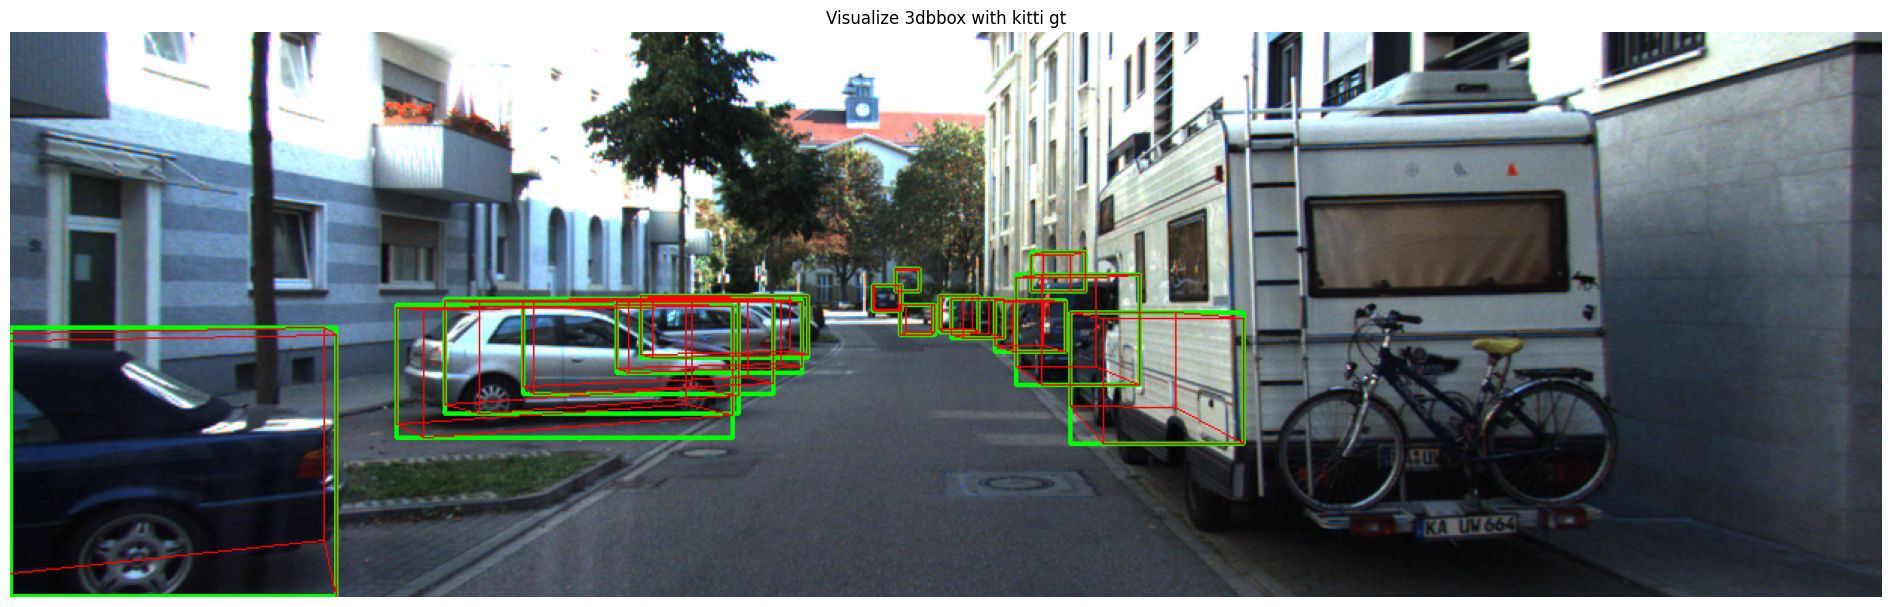

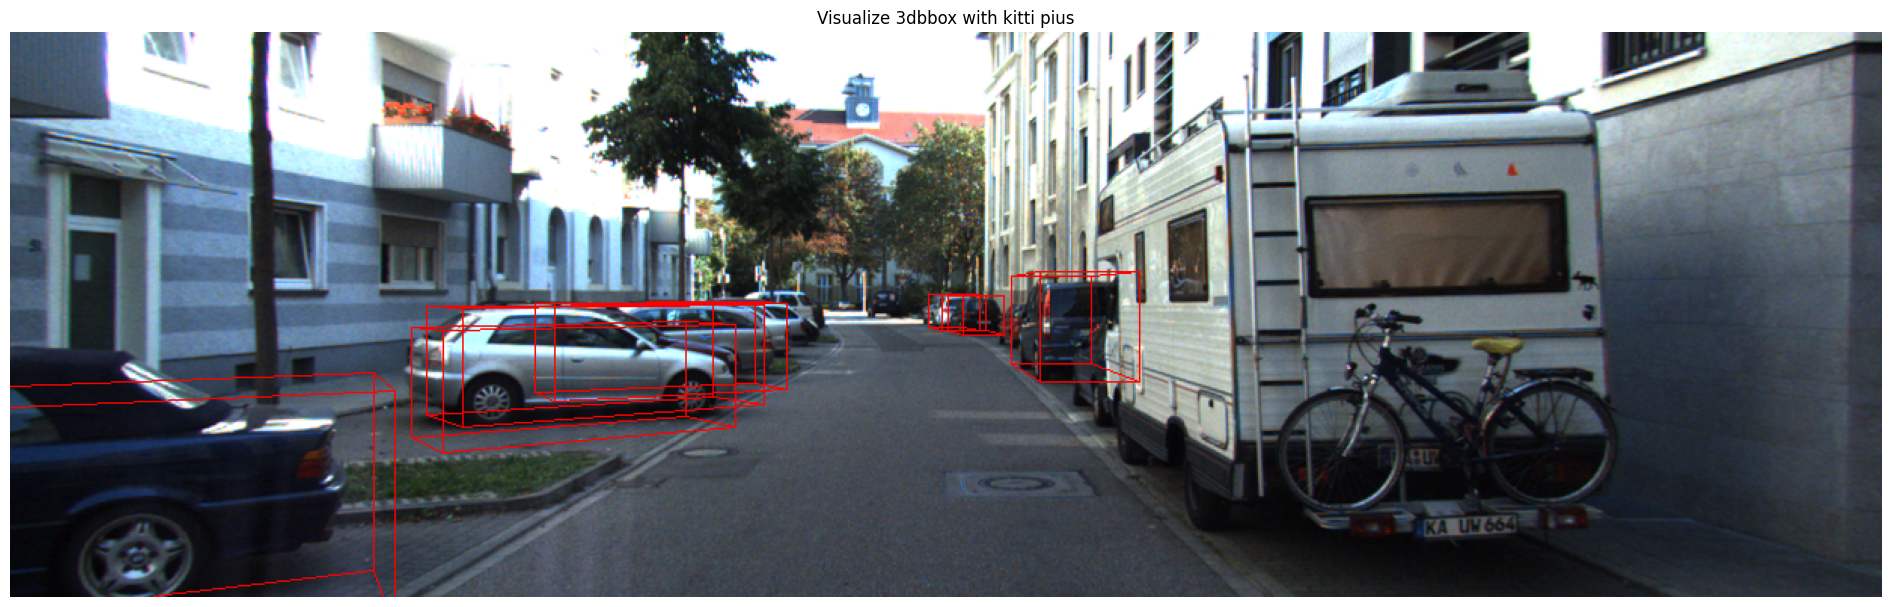

In [85]:
#imshow("Image", image, size = 50, rect=rect_3d_df)
#imshow("Visualize 3dbbox with kitti gt", image, size = 50, corners_2d=corners_3d)
imshow("Visualize 3dbbox with kitti gt", image, size = 80, rect=rect_3d_df, corners_2d=corners_3d)
imshow("Visualize 3dbbox with kitti pius", image, size = 80, corners_2d=corners_3d_pius)

# Visualize 3D boxes on 3D point cloud

In [83]:
#import open3d as o3d


# calculate alpha

In [84]:
null

NameError: name 'null' is not defined

In [ ]:
import math

class obj(object):
    def __init__(self, result3d =  None, label = None):
        if label is not None:
            self.frame = int(label[0])
            self.type = int(label[1])
            self.h = float(label[7])
            self.w = float(label[8])
            self.l = float(label[9])
            self.x = float(label[10])
            self.y = float(label[11])
            self.z = float(label[12])
            self.ry = float(label[13])
        elif result3d is not None:
            result3d = self.splitObjComponents(result3d)
            self.frame = int(result3d[0])
            self.type = int(result3d[1]) # 1: ped, 2: car, 3: cyclist
            self.h = float(result3d[2])
            self.w = float(result3d[3])
            self.l = float(result3d[4])
            self.x = float(result3d[5])
            self.y = float(result3d[6])
            self.z = float(result3d[7])
            self.ry = float(result3d[8])
            self.alpha = float(result3d[9])
    
    def splitObjComponents(self, result3d):
        result3d = result3d.split(",")
        return result3d
      

def normalizeAngle(angle):
    result = angle % (2*math.pi)
    if result < -math.pi:
        result += 2*math.pi
    elif result > math.pi:
        result -= 2*math.pi
    return result

def cal_alpha_ori(obj: obj):  
    alpha = obj.ry
    alpha -= -math.atan2(obj.z, obj.x) -1.5*math.pi 
    alpha = normalizeAngle(alpha)
    return alpha # -1.818032754845337

# frame, type, h, w, l, x, y, z, yaw, alpha
obj1 = obj(result3d="0,2,1.5599,1.5848,3.4791,2.5702,1.5720,9.7190,-1.5595,-1.8180")
cal_alpha_ori(obj1)

-1.818032754845337

In [ ]:
idx = 1
obj2 = obj(label=pointrcnn_label[idx])
print(pointrcnn_label[idx])
cal_alpha_ori(obj2)

['0' '2' '679.6621' '174.1462' '795.2264' '260.7374' '12.8676' '1.5694'
 '1.6609' '4.1846' '2.4745' '1.6008' '15.2377' '-1.5807' '-1.7417']


-1.7416879230707938

In [ ]:
def save_label(label, save_path):
    with open(os.path.join(save_path), "w") as f:
        for line in label:
            f.write(",".join([str(i) for i in line]) + "\n")

In [ ]:
null

NameError: name 'null' is not defined

# fix all pius results

In [ ]:
# fix all pius results
for seq, result_file in enumerate(pointrcnn_result_list_pius):
    pointrcnn_label_pius = load_label(pointrcnn_result_list_pius, seq)
    pointrcnn_label_pius = pointrcnn_label_pius[:, [0, 1, 2, 3, 4, 5, 13, 6, 7, 8, 9, 10, 11, 12]]
    pointrcnn_label_pius = np.insert(pointrcnn_label_pius, 14, 0, axis=1)
    
    # calculate alpha and change pointrcnn_label_pius's 14th column
    for idx, label in enumerate(pointrcnn_label_pius):
        pointrcnn_label_pius[idx][14] = cal_alpha_ori(obj(label=label))
    
    save_label(pointrcnn_label_pius, save_path=result_file)